In [1]:
import sys
sys.path.append('/work/yunruili/2dNMR_project_GNN/')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from load_alignment_graph_nmr import graph_nmr_data, custom_collate_fn
from Comenet_NMR import ComENet
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.cuda.amp import autocast, GradScaler
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nmr_path = '/scratch0/haox/yunruili/cnmr_alignment'
graph_path = '/scratch0/yunruili/nmr_alignment/graph3d'
csv_file = 'filtered_cnmr_smile_3d.csv'
dataset = graph_nmr_data(csv_file, graph_path, nmr_path)
dataloader = DataLoader(dataset, shuffle=True, batch_size=1, collate_fn=custom_collate_fn)

# Create an instance of the network
model = ComENet(in_embed_size=3, out_channels=1, \
                agg_method='sum', hidden_channels=256, out_hidden=[128], \
                    num_layers=3, num_output_layers=2)
msg = model.load_state_dict(torch.load('gnn3d_calignment_sum_hiddendim_256_nlayers_3_noutlayers_2_outhidden_128.pt', map_location='cpu'))
msg

<All keys matched successfully>

tensor([0, 1, 2])


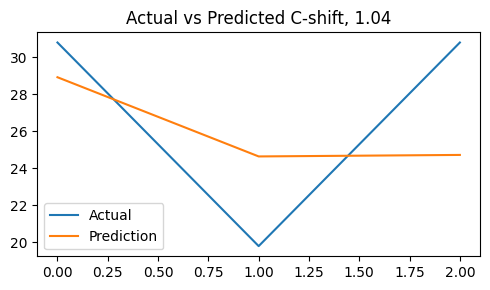

tensor([0, 1, 2, 3, 4, 5])


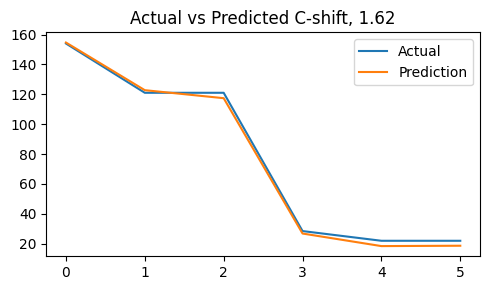

tensor([0, 1, 2, 3, 4, 5])


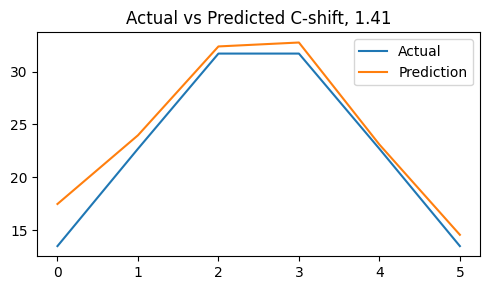

tensor([0, 1, 2, 3, 4, 5, 6])


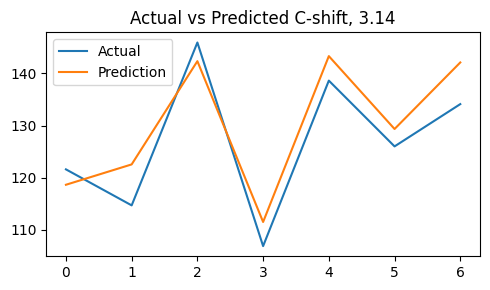

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


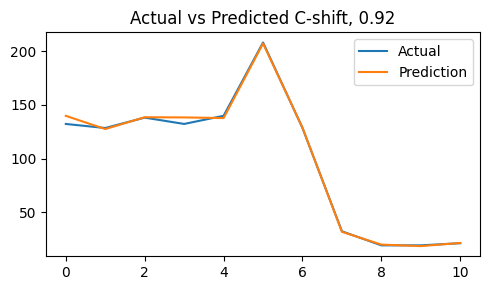

tensor([0, 1, 2, 3, 4, 5, 6, 7])


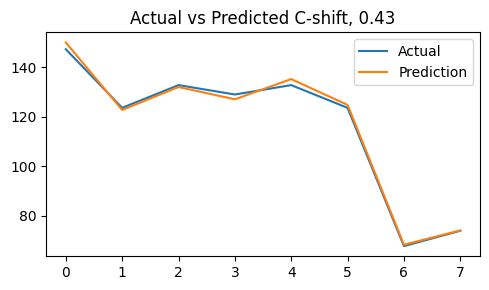

tensor([0, 1, 2, 3, 4])


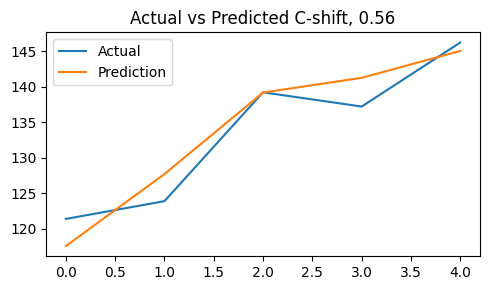

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17])


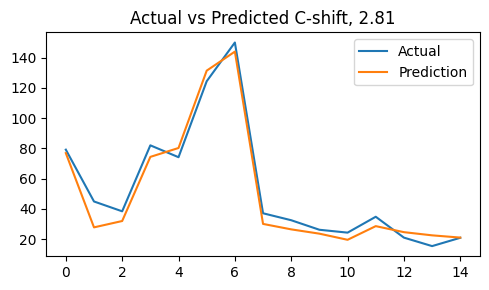

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36])


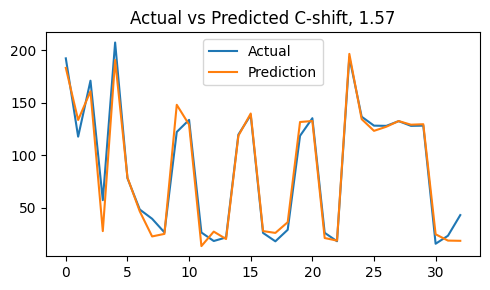

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


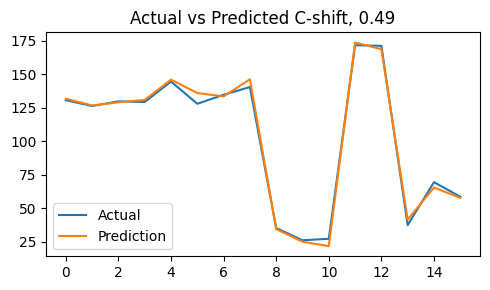

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])


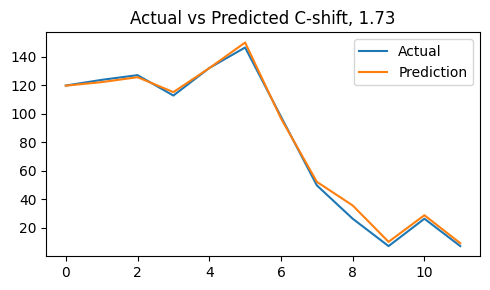

loss 1.4278035380623557


In [15]:
loss = []
for i, (graph, nmr, filename) in enumerate(dataloader):

    out = model(graph)
    nmr = nmr.detach().numpy() * 200
    out = out.detach().numpy() * 200

    error = np.sqrt(np.mean(nmr - out)**2)
    loss.append(error)
    C_node = (graph.x[:, 0] == 5).nonzero(as_tuple=True)[0]
    print(C_node)
    # plot 
    plt.figure(figsize=[5,3])
    plt.plot(np.arange(len(C_node)), nmr, label='Actual')
    plt.plot(np.arange(len(C_node)), out, label='Prediction')
    plt.title('Actual vs Predicted C-shift, %0.2f'%error)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if i == 10:
        break

print('loss', np.mean(np.array(loss)))

In [16]:
loss

[1.03521728515625,
 1.6231971979141235,
 1.4078699350357056,
 3.1363983154296875,
 0.9205100536346436,
 0.43244266510009766,
 0.5605987310409546,
 2.8066437244415283,
 1.5725574493408203,
 0.48540353775024414,
 1.725000023841858]

In [11]:
out

array([[126.43068],
       [141.73839],
       [124.897  ],
       [135.43083],
       [138.23058],
       [130.3853 ]], dtype=float32)

In [16]:
import py3Dmol
import numpy as np
import py3Dmol

def visualize_graph_data(data):
    pos_array = data.pos.numpy().astype(float) if not isinstance(data.pos, np.ndarray) else data.pos
    edge_index = data.edge_index.numpy() if not isinstance(data.edge_index, np.ndarray) else data.edge_index

    # Create a view for the 3D visualization
    view = py3Dmol.view(width=700, height=300)

    # Add atoms to the view
    for i, atom in enumerate(pos_array):
        # Determine the atom type and assign a color
        atom_type = data.x[i, 0].item()  # Assuming the first feature represents atom type
        if atom_type == 5:  # Carbon
            color = 'red'
        elif atom_type == 0:  # Hydrogen
            color = 'blue'
        else:
            color = 'gray'
        
        view.addSphere({'center': {'x': atom[0], 'y': atom[1], 'z': atom[2]}, 
                        'radius': 0.3, 'color': color})
        
    # Add bonds to the view
    for bond in edge_index.T:
        atom1 = pos_array[bond[0]]
        atom2 = pos_array[bond[1]]
        view.addCylinder({'start': {'x': atom1[0], 'y': atom1[1], 'z': atom1[2]},
                          'end': {'x': atom2[0], 'y': atom2[1], 'z': atom2[2]},
                          'radius': 0.05, 'color': 'grey'})

    # Show the molecule
    view.show()


## Evaluate C alignment on 2d data 
### challenge: the gt of c shift is less than the number of C nodes connected to H
#### try hungarian algorithm to assign the best gt to each c nodes connected to H

In [3]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def calculate_optimal_mse(predictions, actuals):
    predictions = np.asarray(predictions)
    actuals = np.asarray(actuals)

    # Expand the cost matrix
    num_predictions = len(predictions)
    cost_matrix = np.zeros((num_predictions, num_predictions))

    # Fill the cost matrix
    for i, pred in enumerate(predictions):
        for j in range(num_predictions):
            # Cycle through actuals for each prediction
            act = actuals[j % len(actuals)]
            cost_matrix[i, j] = (pred - act) ** 2

    # Apply the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Calculate MSE
    mse = cost_matrix[row_ind, col_ind].sum() / num_predictions
    # Create expanded actuals list based on the assignment
    # expanded_actuals = [actuals[c % len(actuals)] for c in col_ind]

    return mse, row_ind, col_ind

# Example usage
# predictions = [3.5, 3.6, 4.0, 5.0, 4.2, 6, 10, 0, 3.7]
# actuals = [3.4, 4.1, 5.1]

# mse, expanded_actuals = calculate_optimal_mse(predictions, actuals)
# print("Optimal MSE:", mse)
# print("Expanded Actuals:", expanded_actuals)



#### dataloader for 2d nmr data
##### returns graph_data, c_peaks, h_peaks, filename
##### c_peaks, [N], h_peaks, [2, N]

In [5]:
# evaluate on 2d NMR data
from torch_geometric.data import DataLoader as loader_2dnmr
from torch.utils.data import Dataset
import pandas as pd

class graph_nmr_data_2d(Dataset):
    '''Returns the index of non-zero values on y-axis and the corresponding x-axis'''
    def __init__(self, csv_file, graph_path, nmr_path, x='C'):
        df = pd.read_csv(csv_file)
        self.file_list = df['File_name'].to_list()
        # filter out Test_*.csv
        self.file_list = [x for x in self.file_list if not x.startswith('Test_')]

        self.nmr_path = nmr_path
        self.graph_path = graph_path
        self.x = x
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, item):
        filename = self.file_list[item].split('.')[0]

        graph_file = os.path.join(self.graph_path, filename + '.pickle')
        graph_data = pickle.load(open(graph_file, 'rb'))
        graph_data.x = graph_data.x.float()

        # use original csv files so that the C nodes are not duplicated
        nmr_file = os.path.join(self.nmr_path, filename + '.csv')
        nmr_data = pd.read_csv(nmr_file)

        # Forward fill the 'No.' column to fill empty values with the previous row's value
        if 'No.' in nmr_data.columns:
            nmr_data['No.'].fillna(method='ffill', inplace=True)
            # Group by both 'No.' and '13C' columns and create a list of '1H' values
            grouped = nmr_data.groupby(['No.', '13C'])['1H'].apply(list).reset_index()
        else:
            grouped = nmr_data.groupby('13C')['1H'].apply(list).reset_index()
        c_list = grouped['13C'].tolist()
        h_list = grouped['1H'].apply(lambda x: x if len(x) > 1 else [x[0], x[0]]).tolist()
        c_peaks = torch.tensor(c_list).float().squeeze()/200
        try:
            h_peaks = torch.tensor(h_list).float()/10
        except Exception as e:
            print(f"Error while converting to tensor for filename: {filename}")
            print(e)
            h_peaks = torch.tensor([])


        # this deals with the 1d mapped out file
        # if self.x == 'C':
        #     nonzero_nmr = nmr_data[nmr_data['1H']!=0]
        # else:
        #     nonzero_nmr = nmr_data[nmr_data['13C']!=0]
        # c_peaks = torch.tensor(nonzero_nmr['13C'].tolist())
        # h_peaks = torch.tensor(nonzero_nmr['1H'].tolist())

        return graph_data, c_peaks, h_peaks, filename
    



In [14]:
graph_path_2dnmr = '/scratch0/yunruili/2dnmr_30k/graph_3d/'
csv_file_2dnmr = '../nmr_smile_solvent_filtered_3dgnn.csv'
nmr_path_2dnmr = '/scratch0/yunruili/2dnmr_30k/csv_30k/'
save_dir = '/scratch0/yunruili/2dnmr_30k/nmr_2dcsv_expanded'

dataset_2dnmr = graph_nmr_data_2d(csv_file_2dnmr, graph_path_2dnmr, nmr_path_2dnmr)
dataloader_2dnmr = loader_2dnmr(dataset_2dnmr, shuffle=True, batch_size=1)

list_files = []
for data in dataloader_2dnmr:
    graph, c_peaks, h_peaks, filename = data
    
    c_nodes = (graph.x[:,0]==5).nonzero(as_tuple=True)[0]
    h_nodes = (graph.x[:, 0] == 0).nonzero(as_tuple=True)[0] 

    out = model(graph)

    ##### calculate the indices of C node connected to H
    # Initialize a list to store C nodes connected to H
    c_nodes_connected_to_h = []
    # Check each C node for connection to any H node
    for c_node in c_nodes:
        # Get indices of edges involving the C node
        edges_of_c = (graph.edge_index[0] == c_node) | (graph.edge_index[1] == c_node)

        # Get all nodes that are connected to this C node
        connected_nodes = torch.cat((graph.edge_index[0][edges_of_c], graph.edge_index[1][edges_of_c])).unique()

        # Check if any of these connected nodes are H nodes
        if any(node in h_nodes for node in connected_nodes):
            c_nodes_connected_to_h.append(c_node.item())
    
    # Convert to a tensor
    c_nodes_connected_to_h = torch.tensor(c_nodes_connected_to_h)

    out2 = out.flatten().detach().numpy()
    c_peaks = c_peaks.squeeze().detach().numpy()
    h_peaks = h_peaks.squeeze().detach().numpy()

    c_index = [i for i, x in enumerate(c_nodes) if x in c_nodes_connected_to_h]
    out2 = out2[c_index]

    print(filename)
    print(len(out2))
    print(len(c_peaks))

    try:
        match_mse, row_ind, col_ind = calculate_optimal_mse(out2, c_peaks)
        # Create expanded actuals list based on the assignment
        c_peaks_expd = [c_peaks[c % len(c_peaks)].item() for c in col_ind]
        h_peaks_expd = [h_peaks[c % len(h_peaks)].tolist() for c in col_ind]
    except Exception as e:
        print(filename)
        continue

    
    print(c_peaks_expd)
    print(out2)
    print(c_peaks)
    print(col_ind)
    break

    # save as pickle
    # c_name = os.path.join(save_dir, '%s_c.pickle'%filename)
    # h_name = os.path.join(save_dir, '%s_h.pickle'%filename)

    # if os.path.exists(c_name) or os.path.exists(h_name):
    #     continue
    
    # # Writing to a pickle file
    # with open(c_name, 'wb') as file:
    #     pickle.dump(c_peaks_expd, file)
    # with open(h_name, 'wb') as file:
    #     pickle.dump(h_peaks_expd, file)


    # print(filename)
    # # print(c_nodes_connected_to_h)
    # print(c_nodes_connected_to_h.shape)
    # # print(c_peaks)
    # print(c_peaks.shape)


/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


('30667',)
22
22
[0.12550000846385956, 0.1810000091791153, 0.35499998927116394, 0.375, 0.36550000309944153, 0.05400000140070915, 0.3734999895095825, 0.3720000088214874, 0.49799999594688416, 0.23399999737739563, 0.1420000046491623, 0.09549999982118607, 0.18950000405311584, 0.13650000095367432, 0.1665000021457672, 0.36500000953674316, 0.11100000143051147, 0.20399999618530273, 0.5889999866485596, 0.3695000112056732, 0.16750000417232513, 0.1835000067949295]
[0.12472434 0.15545604 0.3162806  0.41479665 0.34757608 0.0939164
 0.37212038 0.3712126  0.42180103 0.20997517 0.13279435 0.11492434
 0.16667558 0.12697272 0.13797837 0.33222514 0.12353809 0.1695206
 0.5785917  0.36978388 0.14276294 0.15669443]
[0.111      0.1365     0.3695     0.18100001 0.1895     0.12550001
 0.204      0.1835     0.1665     0.375      0.1675     0.142
 0.234      0.054      0.372      0.589      0.498      0.3655
 0.365      0.3735     0.355      0.0955    ]
[ 5  3 20  9 17 13 19 14 16 12 11 21  4  1  8 18  0  6 15  

#### dataloader for processed 2dnmr data (h peak pickle and c peak pickle files)
##### the processed peaks c/200, h/10

In [17]:
from torch_geometric.data import DataLoader as loader_2dnmr
from torch.utils.data import Dataset
import pandas as pd

class graph_nmr_data_2d_peak(Dataset):
    '''Returns the index of non-zero values on y-axis and the corresponding x-axis'''
    def __init__(self, csv_file, graph_path, nmr_path):
        df = pd.read_csv(csv_file)
        self.file_list = df['File_name'].to_list()
        # filter out Test_*.csv
        self.file_list = [x for x in self.file_list if not x.startswith('Test_')]

        self.nmr_path = nmr_path
        self.graph_path = graph_path
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, item):
        filename = self.file_list[item].split('.')[0]

        graph_file = os.path.join(self.graph_path, filename + '.pickle')
        graph_data = pickle.load(open(graph_file, 'rb'))
        graph_data.x = graph_data.x.float()

        # use processed file to load c and h peaks
        cnmr = os.path.join(self.nmr_path, filename + '_c.pickle')
        cnmr_data = pickle.load(open(cnmr, 'rb'))
        hnmr = os.path.join(self.nmr_path, filename + '_h.pickle')
        hnmr_data = pickle.load(open(hnmr, 'rb'))

        c_peaks = torch.tensor(cnmr_data).view(-1, 1)
        h_peaks = torch.tensor(hnmr_data)


        # this deals with the 1d mapped out file
        # if self.x == 'C':
        #     nonzero_nmr = nmr_data[nmr_data['1H']!=0]
        # else:
        #     nonzero_nmr = nmr_data[nmr_data['13C']!=0]
        # c_peaks = torch.tensor(nonzero_nmr['13C'].tolist())
        # h_peaks = torch.tensor(nonzero_nmr['1H'].tolist())

        return graph_data, c_peaks, h_peaks, filename

In [87]:
graph_path_2dnmr = '/scratch0/yunruili/2dnmr_30k/graph_3d/'
csv_file_2dnmr2 = '../nmr_smile_solvent_filtered2_3dgnn.csv'
nmr_path_2dnmr2 = '/scratch0/yunruili/2dnmr_30k/nmr_2dcsv_expanded/'

dataset_2dnmr = graph_nmr_data_2d_peak(csv_file_2dnmr2, graph_path_2dnmr, nmr_path_2dnmr2)
dataloader_2dnmr = loader_2dnmr(dataset_2dnmr, shuffle=True, batch_size=1)

list_files = []
for data in dataloader_2dnmr:
    graph, c_peaks, h_peaks, filename = data
    
    c_nodes = (graph.x[:,0]==5).nonzero(as_tuple=True)[0]
    h_nodes = (graph.x[:, 0] == 0).nonzero(as_tuple=True)[0] 

    fake_nmr = torch.zeros(len(c_nodes), 1)
    loss, out = model(graph, fake_nmr)

    ##### calculate the indices of C node connected to H
    # Initialize a list to store C nodes connected to H
    c_nodes_connected_to_h = []
    # Check each C node for connection to any H node
    for c_node in c_nodes:
        # Get indices of edges involving the C node
        edges_of_c = (graph.edge_index[0] == c_node) | (graph.edge_index[1] == c_node)

        # Get all nodes that are connected to this C node
        connected_nodes = torch.cat((graph.edge_index[0][edges_of_c], graph.edge_index[1][edges_of_c])).unique()

        # Check if any of these connected nodes are H nodes
        if any(node in h_nodes for node in connected_nodes):
            c_nodes_connected_to_h.append(c_node.item())
    
    # Convert to a tensor
    c_nodes_connected_to_h = torch.tensor(c_nodes_connected_to_h)

    c_index = [i for i, x in enumerate(c_nodes) if x in c_nodes_connected_to_h]
    out2 = out[c_index, :]
    break

/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### Evaluate trained CH peak model


In [18]:
from load_graph_nmr_chpeaks import graph_nmr_data_2d_peak, custom_collate_fn
from torch.utils.data import DataLoader
# from Comenet_NMR import ComENet as trainednet
from Comenet_NMR_CHpeaks import ComENet

nmr_path = '/scratch0/yunruili/2dnmr_30k/nmr_2dcsv_expanded/'
graph_path = '/scratch0/yunruili/2dnmr_30k/graph_3d/'
csv_file = '/work/yunruili/2dNMR_project_GNN/nmr_smile_solvent_filtered2_3dgnn.csv'
dataset = graph_nmr_data_2d_peak(csv_file, graph_path, nmr_path)
data_loader = DataLoader(dataset, batch_size=1, shuffle= True, collate_fn=custom_collate_fn)

model = ComENet(in_embed_size=3, out_channels=1, \
            agg_method='sum', hidden_channels=256, c_out_hidden=[128], h_out_hidden=[128, 64, 64], \
                num_layers=3, num_output_layers=2)
# msg = model.load_state_dict(torch.load('../gnn3d_chshift_sum_hiddendim_256_nlayers_3_noutlayers_2_outhidden_128.pt', map_location='cpu'))
msg = model.load_state_dict(torch.load('../gnn3d_chshift_sum_hiddendim_256_nlayers_3_noutlayers_2_couthidden_12864_houthidden_1286464.pt', map_location='cpu'))
print(msg)



<All keys matched successfully>


In [73]:
for graph, cnmr, hnmr, filename in data_loader:
    print(filename)
    print(cnmr.shape)
    print(hnmr.shape)
    c_shifts, h_shifts = model(graph)

    c_nodes = (graph.x[:,0]==5).nonzero(as_tuple=True)[0]
    h_nodes = (graph.x[:, 0] == 0).nonzero(as_tuple=True)[0] 
    ##### calculate the indices of C node connected to H
    # Initialize a list to store C nodes connected to H
    c_nodes_connected_to_h = []
    # Check each C node for connection to any H node
    for c_node in c_nodes:
        # Get indices of edges involving the C node
        edges_of_c = (graph.edge_index[0] == c_node) | (graph.edge_index[1] == c_node)

        # Get all nodes that are connected to this C node
        connected_nodes = torch.cat((graph.edge_index[0][edges_of_c], graph.edge_index[1][edges_of_c])).unique()

        # Check if any of these connected nodes are H nodes
        if any(node in h_nodes for node in connected_nodes):
            c_nodes_connected_to_h.append(c_node.item())
    # Convert to a tensor
    c_nodes_connected_to_h = torch.tensor(c_nodes_connected_to_h)
    c_index = [i for i, x in enumerate(c_nodes) if x in c_nodes_connected_to_h]
    c_shifts = c_shifts[c_index, :]
    h_shifts = h_shifts[c_index, :]
    print(c_shifts.shape)
    print(h_shifts.shape)
    break


('03657',)
torch.Size([17, 1])
torch.Size([17, 2])
torch.Size([17, 1])
torch.Size([17, 2])


In [74]:
hnmr = hnmr.detach().numpy()
cnmr = cnmr.detach().numpy()
h_shifts = h_shifts.detach().numpy()
c_shifts = c_shifts.detach().numpy()

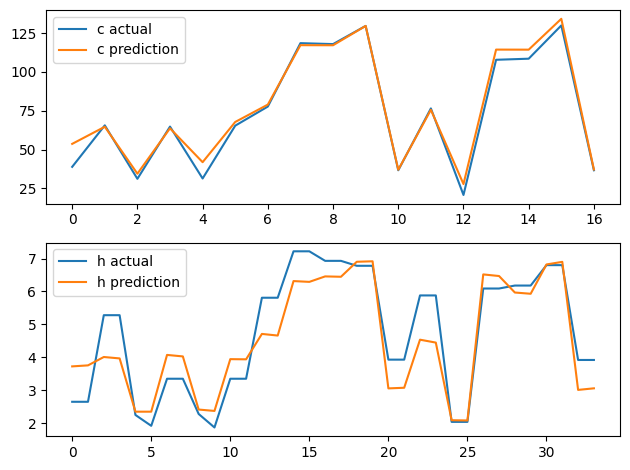

In [75]:
# visualize
import numpy as np
import matplotlib.pyplot as plt

cnmr = cnmr.flatten() * 200
hnmr = hnmr.flatten() * 10
h_shifts = h_shifts.flatten() * 10
c_shifts = c_shifts.flatten() * 200

plt.figure()
plt.subplot(211)
plt.plot(np.arange(len(cnmr)), cnmr, label='c actual')
plt.plot(np.arange(len(c_shifts)), c_shifts, label='c prediction')
plt.legend()
plt.subplot(212)
plt.plot(np.arange(len(hnmr)), hnmr, label='h actual')
plt.plot(np.arange(len(h_shifts)), h_shifts, label='h prediction')
plt.legend()
plt.tight_layout()


In [76]:
print('C error', np.sqrt(np.mean((cnmr - c_shifts)**2)))
print('H error', np.sqrt(np.mean((hnmr - h_shifts)**2)))

C error 5.4051676
H error 0.7655486


In [48]:
hnmr

array([2.81     , 2.81     , 3.5      , 3.55     , 3.01     , 3.01     ,
       1.13     , 1.13     , 3.8      , 3.8      , 4.01     , 4.01     ,
       3.24     , 3.24     , 3.9899998, 3.9899998, 3.6      , 3.6      ],
      dtype=float32)

In [12]:
h_shifts

array([[0.142092  , 0.13968533],
       [0.4485992 , 0.44781718],
       [0.25798777, 0.25521326],
       [0.13523653, 0.13379194],
       [0.16678934, 0.16677624],
       [0.18327865, 0.18213016],
       [0.17622319, 0.17476548],
       [0.13749552, 0.1386641 ],
       [0.21615171, 0.21553902],
       [0.21339557, 0.21115941],
       [0.17625463, 0.17359611],
       [0.55964625, 0.55810565],
       [0.17420156, 0.17257993],
       [0.16321455, 0.16261555],
       [0.3685346 , 0.36813435],
       [0.2150406 , 0.21293028],
       [0.24244604, 0.24163574],
       [0.11211452, 0.11072439],
       [0.1325301 , 0.13013989],
       [0.47112235, 0.4709679 ],
       [0.28815377, 0.2839979 ],
       [0.10763405, 0.10577853],
       [0.16084996, 0.16105884],
       [0.12295616, 0.12281621],
       [0.18478578, 0.1827735 ],
       [0.133724  , 0.13313842],
       [0.24810308, 0.2470625 ],
       [0.3371642 , 0.33645055],
       [0.20556268, 0.2038977 ],
       [0.4892834 , 0.48614275],
       [0.

#### evaluate multitask alignment model

In [2]:
sys.path.append('/work/yunruili/2dNMR_project_GNN/')
from load_graph_cnmr_hnmr_alignment import graph_nmr_alignment_data, custom_collate_fn, CustomBatchSampler
from Comenet_NMR_multitask import ComENet

graph_path = '/scratch0/haox/2DNMR_prediction_gt/Datasets/graph3d/'
nmr_path = '/scratch0/haox/yunruili/'
# cnmr_path = '/scratch0/haox/yunruili/cnmr_alignment'
# hnmr_path = '/scratch0/haox/yunruili/hnmr_alignment'
csv_cnmr = '../filtered_cnmr_smile_dataset_22k.csv'
csv_hnmr = '../filtered_hnmr_smile_dataset_67.csv'
csv_common = '../filtered_common_smile_dataset_1600.csv'
dataset_c = graph_nmr_alignment_data(csv_cnmr, graph_path, nmr_path, type='c')
dataset_h = graph_nmr_alignment_data(csv_hnmr, graph_path, nmr_path, type='h')
dataset_ch = graph_nmr_alignment_data(csv_common, graph_path, nmr_path, type='both')

# Set the seed for reproducibility
torch.manual_seed(0)  # Replace your_seed with your chosen seed value

# Define the proportions or absolute sizes for your train and val sets
train_size_c = int(0.8 * len(dataset_c))
val_size_c = len(dataset_c) - train_size_c

train_size_h = int(0.8 * len(dataset_h))
val_size_h = len(dataset_h) - train_size_h

train_size_ch = int(0.8 * len(dataset_ch))
val_size_ch = len(dataset_ch) - train_size_ch

# Split the datasets
train_dataset_c, val_dataset_c = random_split(dataset_c, [train_size_c, val_size_c])
train_dataset_h, val_dataset_h = random_split(dataset_h, [train_size_h, val_size_h])
train_dataset_ch, val_dataset_ch = random_split(dataset_ch, [train_size_ch, val_size_ch])

# Create DataLoaders for training and validation sets
train_dataloader_c = DataLoader(train_dataset_c, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader_c = DataLoader(val_dataset_c, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

train_dataloader_h = DataLoader(train_dataset_h, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader_h = DataLoader(val_dataset_h, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

train_dataloader_ch = DataLoader(train_dataset_ch, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader_ch = DataLoader(val_dataset_ch, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

# Now you can create custom loaders for each set
train_custom_loader = CustomBatchSampler(train_dataloader_c, train_dataloader_ch, train_dataloader_h, n1=7, n2=80)
val_custom_loader = CustomBatchSampler(val_dataloader_c, val_dataloader_ch, val_dataloader_h, n1=14, n2=141)

In [3]:
hc = 256
chc=[128]
hhc=[128, 64, 64]
n = 3
n_out = 2
model = ComENet(in_embed_size=3, c_out_channels=1, h_out_channels=1, agg_method='sum',\
     hidden_channels=hc, c_out_hidden=chc, h_out_hidden=hhc, num_layers=n, num_output_layers=n_out)
msg = model.load_state_dict(torch.load(
    '../gnn3d_multi_align_sum_hiddendim_%d_nlayers_%d_noutlayers_%d_couthidden_%s_houthidden_%s.pt'\
    %(hc, n, n_out, ''.join(str(i) for i in chc), ''.join(str(i) for i in hhc)), map_location='cpu'))
print(msg)



<All keys matched successfully>


In [4]:
model2 = ComENet(in_embed_size=3, c_out_channels=1, h_out_channels=2, agg_method='sum',\
     hidden_channels=hc, c_out_hidden=chc, h_out_hidden=hhc, num_layers=n, num_output_layers=n_out)

In [10]:
for name, module in model.named_children():
    # Check if the current model has the component
    if hasattr(model2, name):
        # Special handling for the 'h_projection' component
        if name == 'lin_out_h':
            # Ensure the h_projection module in the current model also has a 'model' attribute
            if hasattr(getattr(model2, name), 'model'):
                # Copy all layers of 'h_projection.model' except the last one
                h_proj_model = getattr(model2, name).model
                for idx, sub_module in enumerate(module.model):
                    if idx < len(module.model) - 1:  # Skip the last layer
                        h_proj_model[idx].load_state_dict(sub_module.state_dict())
                    else:
                        # Handle the last layer
                        source_layer = sub_module
                        target_layer = h_proj_model[idx]

                        with torch.no_grad():
                            # Duplicate the weights and biases for each output channel
                            # Assuming the output channels are doubled
                            duplicated_weights = torch.repeat_interleave(source_layer.weight.data, 2, dim=0)
                            duplicated_bias = torch.repeat_interleave(source_layer.bias.data, 2, dim=0)

                            # Check if the dimensions match
                            if duplicated_weights.shape == target_layer.weight.data.shape and \
                            duplicated_bias.shape == target_layer.bias.data.shape:
                                target_layer.weight.data = duplicated_weights
                                target_layer.bias.data = duplicated_bias
                            else:
                                print(f"Dimension mismatch in layer {name}")

        else:
            # For other components, directly copy the state dict
            getattr(model2, name).load_state_dict(module.state_dict())

for layer in model2.lin_out_h.model:
    for param in layer.parameters():
        print(layer, param.requires_grad)  # Check the status

        # Optionally, set requires_grad
        # param.requires_grad = [True/False based on your requirement]


Linear(in_features=256, out_features=128, bias=True) True
Linear(in_features=256, out_features=128, bias=True) True
Linear(in_features=128, out_features=64, bias=True) True
Linear(in_features=128, out_features=64, bias=True) True
Linear(in_features=64, out_features=64, bias=True) True
Linear(in_features=64, out_features=64, bias=True) True
Linear(in_features=64, out_features=2, bias=True) True
Linear(in_features=64, out_features=2, bias=True) True


In [19]:
# check if the parameters are copied correctly
# Assuming 'model' is your target model and 'trained_model' is the model with trained parameters
for idx, (model_layer, trained_layer) in enumerate(zip(model2.lin_out_h.model, model.lin_out_h.model)):
    if idx < len(model.lin_out_h.model) - 1:  # Skip the last layer
        # Compare parameters of the current layer in both models
        are_same = all((torch.equal(a, b) for a, b in zip(model_layer.parameters(), trained_layer.parameters())))
        
    else:
        # For the last layer, compare only the first half of the parameters
        are_same = True
        for a, b in zip(model_layer.parameters(), trained_layer.parameters()):
            half_size = a.data.size(0) // 2  # Assuming the output features are doubled
            are_same = are_same and torch.equal(a.data[:half_size], b.data)
    print(f"Layer {idx} parameters are {'identical' if are_same else 'different'}")


Layer 0 parameters are identical
Layer 1 parameters are identical
Layer 2 parameters are identical
Layer 3 parameters are identical
Layer 4 parameters are identical
Layer 5 parameters are identical


In [11]:
print(model.lin_out_h)

Projection(
  (model): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [12]:
print(model2.lin_out_h)

Projection(
  (model): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [4]:
for i, batch in enumerate(val_dataloader_ch):
    # if i%50 == 0:
    #     print(i)
    graph, cnmr, hnmr, filename = batch
    c_shifts, h_shifts = model(graph)
    if graph[0].has_h:
        if graph[0].has_c:
            loss = (nn.MSELoss()(c_shifts, cnmr) + nn.MSELoss()(h_shifts, hnmr))/2
        else:
            loss = nn.MSELoss()(h_shifts, hnmr)
    else:
        loss = nn.MSELoss()(c_shifts, cnmr)
    break

In [5]:
hnmr = hnmr.detach().numpy() if hnmr is not None else np.array([0])
cnmr = cnmr.detach().numpy() if cnmr is not None else np.array([0])
h_shifts = h_shifts.detach().numpy() if h_shifts is not None else np.array([0])
c_shifts = c_shifts.detach().numpy() if c_shifts is not None else np.array([0])

cnmr = cnmr.flatten() * 200
hnmr = hnmr.flatten() * 10
h_shifts = h_shifts.flatten() * 10
c_shifts = c_shifts.flatten() * 200


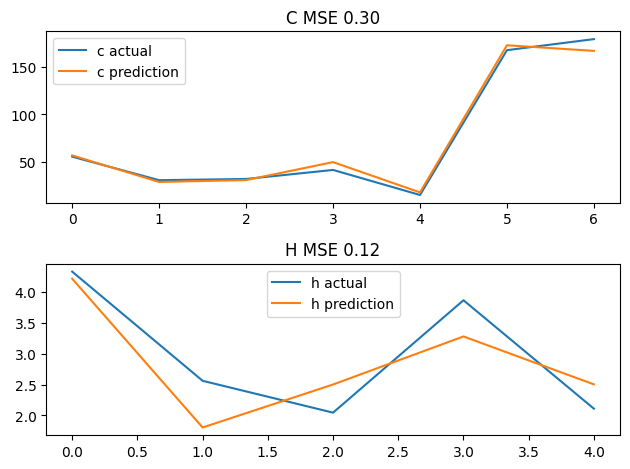

In [6]:
# visualize
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(211)
plt.plot(np.arange(len(cnmr)), cnmr, label='c actual')
plt.plot(np.arange(len(c_shifts)), c_shifts, label='c prediction')
error = np.sqrt(np.mean(c_shifts - cnmr)**2)
plt.title('C MSE %0.2f'%error)
plt.legend()
plt.subplot(212)
plt.plot(np.arange(len(hnmr)), hnmr, label='h actual')
plt.plot(np.arange(len(h_shifts)), h_shifts, label='h prediction')
error = np.sqrt(np.mean(h_shifts - hnmr)**2)
plt.title('H MSE %0.2f'%error)
plt.legend()
plt.tight_layout()


In [7]:
h_shifts

array([4.2074766, 1.8064557, 2.5002189, 3.2757485, 2.5020537],
      dtype=float32)

In [8]:
hnmr

array([4.322    , 2.56     , 2.046    , 3.8599997, 2.11     ],
      dtype=float32)

In [9]:
filename

('020200768',)

#### apply multi-align model on 2d NMR data

In [21]:
# evaluate on 2d NMR data
from torch_geometric.data import DataLoader as loader_2dnmr
from torch.utils.data import Dataset
import pandas as pd

class graph_nmr_data_2d(Dataset):
    '''Returns the index of non-zero values on y-axis and the corresponding x-axis'''
    def __init__(self, csv_file, graph_path, nmr_path, x='C'):
        df = pd.read_csv(csv_file)
        self.file_list = df['File_name'].to_list()
        # filter out Test_*.csv
        self.file_list = [x for x in self.file_list if not x.startswith('Test_')]

        self.nmr_path = nmr_path
        self.graph_path = graph_path
        self.x = x
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, item):
        filename = self.file_list[item].split('.')[0]

        graph_file = os.path.join(self.graph_path, filename + '.pickle')
        graph_data = pickle.load(open(graph_file, 'rb'))
        graph_data.x = graph_data.x.float()
        
        graph_data.has_c = True
        graph_data.has_h = True

        # use original csv files so that the C nodes are not duplicated
        nmr_file = os.path.join(self.nmr_path, filename + '.csv')
        nmr_data = pd.read_csv(nmr_file)

        # Forward fill the 'No.' column to fill empty values with the previous row's value
        if 'No.' in nmr_data.columns:
            nmr_data['No.'].fillna(method='ffill', inplace=True)
            # Group by both 'No.' and '13C' columns and create a list of '1H' values
            grouped = nmr_data.groupby(['No.', '13C'])['1H'].apply(list).reset_index()
        else:
            grouped = nmr_data.groupby('13C')['1H'].apply(list).reset_index()
        c_list = grouped['13C'].tolist()
        h_list = grouped['1H'].apply(lambda x: x if len(x) > 1 else [x[0], x[0]]).tolist()
        c_peaks = torch.tensor(c_list).float().squeeze()/200
        try:
            h_peaks = torch.tensor(h_list).float()/10
        except Exception as e:
            print(f"Error while converting to tensor for filename: {filename}")
            print(e)
            h_peaks = torch.tensor([])


        # this deals with the 1d mapped out file
        # if self.x == 'C':
        #     nonzero_nmr = nmr_data[nmr_data['1H']!=0]
        # else:
        #     nonzero_nmr = nmr_data[nmr_data['13C']!=0]
        # c_peaks = torch.tensor(nonzero_nmr['13C'].tolist())
        # h_peaks = torch.tensor(nonzero_nmr['1H'].tolist())

        return graph_data, c_peaks, h_peaks, filename

In [38]:
graph_path_2dnmr = '/scratch0/yunruili/2dnmr_30k/graph_3d/'
csv_file_2dnmr = '../nmr_smile_solvent_filtered2_3dgnn.csv'
nmr_path_2dnmr = '/scratch0/yunruili/2dnmr_30k/csv_30k/'
save_dir = '/scratch0/yunruili/2dnmr_30k/nmr_2dcsv_chmatched'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

dataset_2dnmr = graph_nmr_data_2d(csv_file_2dnmr, graph_path_2dnmr, nmr_path_2dnmr)
dataloader_2dnmr = loader_2dnmr(dataset_2dnmr, shuffle=False, batch_size=1)

list_files = []
for i, data in enumerate(dataloader_2dnmr):
    graph, cnmr, hnmr, filename = data
    
    c_nodes = (graph.x[:,0]==5).nonzero(as_tuple=True)[0]
    h_nodes = (graph.x[:, 0] == 0).nonzero(as_tuple=True)[0] 

    c_shifts, h_shifts = model(graph)

    ##### calculate the indices of C node connected to H
    # Initialize a list to store C nodes connected to H
    c_nodes_connected_to_h = []
    # Check each C node for connection to any H node
    for c_node in c_nodes:
        # Get indices of edges involving the C node
        edges_of_c = (graph.edge_index[0] == c_node) | (graph.edge_index[1] == c_node)

        # Get all nodes that are connected to this C node
        connected_nodes = torch.cat((graph.edge_index[0][edges_of_c], graph.edge_index[1][edges_of_c])).unique()

        # Check if any of these connected nodes are H nodes
        if any(node in h_nodes for node in connected_nodes):
            c_nodes_connected_to_h.append(c_node.item())
    
    # Convert to a tensor
    c_nodes_connected_to_h = torch.tensor(c_nodes_connected_to_h)

    c_shifts = c_shifts.flatten().detach().numpy()
    h_shifts = h_shifts.flatten().detach().numpy()
    cnmr = cnmr.squeeze().detach().numpy()
    hnmr = hnmr.squeeze().detach().numpy()

    c_index = [i for i, x in enumerate(c_nodes) if x in c_nodes_connected_to_h]
    c_shifts = c_shifts[c_index]

    print(filename)
    print(len(c_shifts), len(h_shifts))
    print(len(cnmr), len(hnmr))

    # make c-h pairs for ground truth and prediction
    hnmr = np.mean(hnmr, axis=1)
    pred = np.stack([c_shifts, h_shifts], axis=1)
    gt = np.stack([cnmr, hnmr], axis=1)

    if i ==0:
        break




('18162',)
18 18
18 18


/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [39]:
pred

array([[0.08599769, 0.12025841],
       [0.39847407, 0.44900137],
       [0.20438495, 0.25110975],
       [0.12776999, 0.1771736 ],
       [0.1393801 , 0.13519876],
       [0.23565598, 0.24160792],
       [0.13236368, 0.1799757 ],
       [0.12830888, 0.1325911 ],
       [0.14418037, 0.15805663],
       [0.16651206, 0.15077056],
       [0.10847443, 0.21700712],
       [0.5657312 , 0.5808864 ],
       [0.17172599, 0.1645288 ],
       [0.12986453, 0.15917829],
       [0.28655097, 0.31548595],
       [0.16220249, 0.24745317],
       [0.19932687, 0.14952438],
       [0.12552598, 0.11567938]], dtype=float32)

In [40]:
gt

array([[0.191     , 0.1495    ],
       [0.1445    , 0.159     ],
       [0.299     , 0.234     ],
       [0.19700001, 0.228     ],
       [0.601     , 0.53499997],
       [0.161     , 0.181     ],
       [0.153     , 0.23599999],
       [0.25      , 0.102     ],
       [0.103     , 0.17250001],
       [0.1565    , 0.1825    ],
       [0.2775    , 0.129     ],
       [0.1355    , 0.14899999],
       [0.11149999, 0.178     ],
       [0.2495    , 0.22      ],
       [0.0975    , 0.10700001],
       [0.3775    , 0.467     ],
       [0.08149999, 0.136     ],
       [0.1665    , 0.245     ]], dtype=float32)

In [43]:
a = pickle.load(open(os.path.join(save_dir, '%s_c.pickle'%filename), 'rb'))
np.mean((a-pred[:, 0])**2)

0.028292332

In [31]:
hnmr

array([0.1495    , 0.159     , 0.234     , 0.228     , 0.53499997,
       0.181     , 0.23599999, 0.102     , 0.17250001, 0.1825    ,
       0.129     , 0.14899999, 0.178     , 0.22      , 0.10700001,
       0.467     , 0.136     , 0.245     ], dtype=float32)

In [ ]:
def extend_ch_lable(c_pred, c_gt, h_pred, h_gt):
    N = c_pred.shape[0]
    # Step 1: Calculate distances between elements in C and c2
    distance_matrix = np.abs(c_pred, c_gt.T)  # Broadcasting to create an N x m matrix

    # Step 2: Find closest matches for each element in C
    closest_indices = np.argmin(distance_matrix, axis=1)

    # Step 3: Resolve ambiguities using H and h2
    for i, c_index in enumerate(closest_indices):
        # Find all c2 elements that are equally close
        equal_elements = np.where(distance_matrix[i] == distance_matrix[i, c_index])[0]

        if len(equal_elements) > 1:
            # Resolve ambiguity
            h_distances = np.linalg.norm(h_pred[i] - h_gt[equal_elements], axis=1)
            closest_indices[i] = equal_elements[np.argmin(h_distances)]

    # Results
    matched_pairs = list(zip(range(N), closest_indices))

    # Output the matched pairs
    print("Matched Pairs (C to c2):", matched_pairs)


In [23]:
c_shifts.shape

(18,)